In [1]:
from dataclasses import dataclass, astuple
from typing import Dict, Tuple, Union, Optional
from numbers import Number
import wolframclient
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl, wlexpr
from wolframclient.serializers import export
from fractions import Fraction
from graphviz import Digraph
import math
import sympy as sym
from itertools import product

import numpy as np

In [ ]:
"""
Set up wolfram session

Get wolfram kernel path: https://reference.wolfram.com/language/WolframClientForPython/docpages/basic_usages.html
Get wolfram license: https://software.berkeley.edu/mathematica
"""

wolfram_kernel_path_macos = "/Applications/Wolfram.app/Contents/MacOS/WolframKernel"
wolfram_kernel_path_linux = "/usr/local/Wolfram/Desktop/11.3/Executables/WolframKernel"
wolfram_kernel_path_windows = (
    "C:\\Program Files\\Wolfram Research\\Wolfram Desktop\\11.3\\WolframKernel.exe"
)

"""Define your own desired wolfram_kernel_path"""
my_wolfram_kernel_path = wolfram_kernel_path_macos

# If you get an error, you may need to install wolframclient using pip and install wolfram language on your computer
test_wolfram_session = WolframLanguageSession(wolfram_kernel_path_macos)
test_wolfram_session.terminate()


def wolfram_evals(
    wolfram_expression: list[wolframclient.language.expression.WLInputExpression],
    kernel_path: str = my_wolfram_kernel_path,
) -> list[wolframclient.language.expression.WLFunction]:
    """
    Evaluate a list of wolfram expressions in series with the same kernel and then close
    Return each result in a list following the input order
    """
    results = []
    with WolframLanguageSession(kernel_path) as session:
        for expression in wolfram_expression:
            results.append(session.evaluate(wolfram_expression))
    return results


def wolfram_eval(
    wolfram_expression: wolframclient.language.expression.WLInputExpression,
    kernel_path: str = my_wolfram_kernel_path,
) -> wolframclient.language.expression.WLFunction:
    """
    Evaluate a single wolfram expression and close
    """
    with WolframLanguageSession(kernel_path) as session:
        result = session.evaluate(wolfram_expression)
        return result

In [3]:
lossless_numerics = Union[Fraction, sym.Symbol, sym.Rational]


@dataclass
class StateTransition:
    """
    no self transition allowed (does not effect modeling theoretically due to exponential distribution memorylessness)
    """

    state_name: str
    transition_rates: list[Tuple[str, lossless_numerics]]


@dataclass
class ContinuousMarkovModel:
    initial_state_dist: dict[str, lossless_numerics]
    state_transitions: list[StateTransition]


@dataclass
class FailureParameters:
    """
    Global parameters useful for modeling a node's failure/recovery behavior
    """

    failure_rps: lossless_numerics
    recovery_rps: lossless_numerics
    human_recovery_rps: lossless_numerics
    update_rps: lossless_numerics
    outdate_rps: lossless_numerics


def get_graphviz(
    markov_model: ContinuousMarkovModel,
    *,
    simple_graph: bool = False,
    show_weights: bool = False,
    node_to_group: Optional[dict[str:str]] = None,
    hide_edges_to_nodes: Optional[set[str]] = None,
    source_node: Optional[str] = None,
) -> Digraph:
    if node_to_group is None:
        node_to_group = {}
    if hide_edges_to_nodes is None:
        hide_edges_to_nodes = set()

    dot = Digraph(strict="true")
    dot.attr(rankdir="LR")
    dot.attr(newrank="true")
    dot.attr(concentrate="true")
    node_to_id = {}
    for x in markov_model.state_transitions:
        if x.state_name not in node_to_id:
            node_to_id[x.state_name] = str(len(node_to_id))
        dot.node(
            node_to_id[x.state_name],
            label=x.state_name,
            group=node_to_group.get(x.state_name, None),
        )

    for state_transition in markov_model.state_transitions:
        starting_node = state_transition.state_name
        for transition in state_transition.transition_rates:
            ending_node, rate = transition
            if ending_node in hide_edges_to_nodes:
                continue
            if show_weights:
                if isinstance(rate, Number):
                    dot.edge(
                        node_to_id[starting_node],
                        node_to_id[ending_node],
                        label="{0:.4g}".format(float(rate)),
                    )
                else:
                    dot.edge(
                        node_to_id[starting_node], node_to_id[ending_node], str(rate)
                    )
            else:
                dot.edge(node_to_id[starting_node], node_to_id[ending_node])

    if simple_graph:
        return dot

    source_group_id = node_to_group.get(source_node)
    for group_id in set(node_to_group.values()):
        nodes_in_group = [k for k, v in node_to_group.items() if v == group_id]
        with dot.subgraph(name=f"cluster_{group_id}") as sub:
            sub.attr(pencolor="gray")
            sub.attr(style="dashed")
            for node in nodes_in_group:
                sub.node(node_to_id[node])
            if group_id == source_group_id:
                sub.attr(rank="min")
            else:
                sub.attr(rank="same")

    # Hack to make Failed appear rightmost
    if "Failed" in node_to_id:
        with dot.subgraph() as sub:
            sub.attr(rank="sink")
            sub.node(node_to_id["Failed"])

    return dot


def working_and_backup_grouping(markov_model: ContinuousMarkovModel) -> dict[str, str]:
    working_and_backup_grouping = {}
    for state_transition in markov_model.state_transitions:
        cur_state_name = state_transition.state_name
        numbers = cur_state_name.split(":")
        if any(not number.isnumeric() for number in numbers):
            continue
        num_backups = (
            "0" if len(numbers) < 4 else str(int(numbers[2]) + int(numbers[3]))
        )
        num_working = "0"
        for number in numbers[:2]:
            num_working = str(int(num_working) + int(number))
        working_and_backup_grouping[cur_state_name] = num_working + "_" + num_backups
    return working_and_backup_grouping


def get_state_to_id_dict(
    markov_model: ContinuousMarkovModel,
) -> Optional[dict[str, int]]:
    """
    Algorithm:
    * state_transitions[i].cur_state_name becomes state i
    * states in initial_state_dist are ignored
    """
    state_name_to_id = {}
    for i, state_transition in enumerate(markov_model.state_transitions):
        if state_transition.state_name in state_name_to_id:
            print(
                f"Error -- cannot generate transition matrix, found duplicate state [state_transition.state_name]"
            )
            return
        state_name_to_id[state_transition.state_name] = i
    return state_name_to_id


def get_wolfram_failed_id(cmm: ContinuousMarkovModel) -> int:
    return get_state_to_id_dict(cmm)["Failed"] + 1


def get_initial_state_dist(
    markov_model: ContinuousMarkovModel,
) -> Optional[list[lossless_numerics]]:
    state_name_to_id = get_state_to_id_dict(markov_model)
    if state_name_to_id is None:
        return
    num_states = len(state_name_to_id)
    output_vector = [0] * num_states
    for state_name, probability in markov_model.initial_state_dist.items():
        state_id = state_name_to_id[state_name]
        output_vector[state_id] = probability
    return output_vector


def get_transition_matrix(markov_model: ContinuousMarkovModel) -> Optional[sym.Matrix]:
    """
    Algorithm:
    1. all_transition_rates[i].cur_state_name becomes state i
    2. For output matrix Q,
            if i != j: let Q[i][j] = be transition rate of i->j or zero if no rate specified
            otw:       let Q[i][i] = be -(Q[i][0] + Q[i][1] +...+ Q[i][i-1] + Q[i][i+1] +...+Q[i][len(all_transition_rates])
    *** 2b is required for wolfram logic
    """
    state_name_to_id = get_state_to_id_dict(markov_model)
    if state_name_to_id is None:
        return None
    num_states = len(state_name_to_id)
    output_matrix = sym.zeros(num_states, num_states)
    # Set transitions to be the rate per second
    for state_transition in markov_model.state_transitions:
        starting_state_name = state_transition.state_name
        starting_state_id = state_name_to_id[starting_state_name]
        for ending_state_name, transition_rate in state_transition.transition_rates:
            ending_state_id = state_name_to_id[ending_state_name]
            output_matrix[starting_state_id, ending_state_id] = transition_rate

    # Set diagonal to be negative total transition
    for i in range(output_matrix.shape[0]):
        row = output_matrix.row(i)
        output_matrix[i, i] = -np.sum(row)

    return output_matrix


def get_wolfram_markov_model(markov_model: ContinuousMarkovModel):
    """
    Convert a markov model into a wolfram language object
    """
    transition_matrix = wlexpr(
        sym.printing.mathematica.mathematica_code(get_transition_matrix(markov_model))
    )
    initial_state_dist = wlexpr(
        sym.printing.mathematica.mathematica_code(get_initial_state_dist(markov_model))
    )
    return wl.ContinuousMarkovProcess(initial_state_dist, transition_matrix)


def convert_wolfram_number(n) -> float:
    if type(n) == int:
        return float(n)
    if type(n) == wolframclient.language.expression.WLFunction:
        return float(Fraction(n[0], n[1]))
    print(f"unexpected type {type(n)}")
    return


def generate_fractions(start: Fraction, end: Fraction, num: int) -> list[Fraction]:
    """
    Generates a list of equally spaced fractions within a range.

    Args:
      start: The starting value (inclusive) as a Fraction.
      end: The ending value (inclusive) as a Fraction.
      num: The number of fractions to generate.

    Returns:
      A list of Fractions.
    """
    num = int(num)
    if num <= 0:
        return []
    if num == 1:
        return [start + end / 2]

    step = (end - start) / (num - 1)
    return [start + i * step for i in range(num)]

In [4]:
def fill_empty_transitions(markov_model: ContinuousMarkovModel):
    states_with_transitions = set(
        [x.state_name for x in markov_model.state_transitions]
    )
    states_in_total = (
        [x.state_name for x in markov_model.state_transitions]
        + [
            transition_rate[0]
            for state_transition in markov_model.state_transitions
            for transition_rate in state_transition.transition_rates
        ]
        + list(markov_model.initial_state_dist.keys())
    )
    for state in states_in_total:
        if state not in states_with_transitions:
            markov_model.state_transitions.append(
                StateTransition(state_name=state, transition_rates=[])
            )


def get_cmm(
    num_nodes: int,
    failure_params: FailureParameters,
    *,
    initial_state_dist: Optional[dict[str, lossless_numerics]] = None,
) -> ContinuousMarkovModel:
    if initial_state_dist is None:
        initial_state_dist = {"0f": Fraction(1, 1)}
    max_num_failures = int(math.ceil(num_nodes / 2)) - 1
    state_transitions = [
        StateTransition(  # 0f can only fail, no recovery
            state_name="0f",
            transition_rates=[("1f", num_nodes * failure_params.failure_rps)],
        ),
        StateTransition(  # Failed can only recover, not fail
            state_name="Failed",
            transition_rates=[("0f", failure_params.human_recovery_rps)],
        ),
        StateTransition(  # Failed - 1 transitions to Failed instead of '<num_failed>f'
            state_name=f"{max_num_failures}f",
            transition_rates=[
                (f"{max_num_failures - 1}f", failure_params.recovery_rps),
                ("Failed", (num_nodes - max_num_failures) * failure_params.failure_rps),
            ],
        ),
    ]
    for num_failures in range(1, max_num_failures):
        cur_num_working_nodes = num_nodes - num_failures
        state_transitions.append(
            StateTransition(
                state_name=f"{num_failures}f",
                transition_rates=[
                    (f"{num_failures - 1}f", failure_params.recovery_rps),
                    (
                        f"{num_failures + 1}f",
                        cur_num_working_nodes * failure_params.failure_rps,
                    ),
                ],
            )
        )
    return ContinuousMarkovModel(
        initial_state_dist=initial_state_dist,
        state_transitions=state_transitions,
    )


def get_dr_cmm(
    num_nodes: int,
    failure_params: FailureParameters,
    *,
    initial_state_dist: Optional[dict[str, lossless_numerics]] = None,
) -> ContinuousMarkovModel:
    if initial_state_dist is None:
        initial_state_dist = {f"{num_nodes}:0": Fraction(1, 1)}
    state_transitions = [
        StateTransition(  # Failed can only recover, not fail
            state_name="Failed",
            transition_rates=[(f"{num_nodes}:0", failure_params.human_recovery_rps)],
        ),
    ]

    unexplored_states = [f"{num_nodes}:0"]
    discovered_states = set(["Failed", f"{num_nodes}:0"])
    max_failures = int(math.ceil(num_nodes / 2)) - 1
    min_updated_to_commit = num_nodes - max_failures

    while len(unexplored_states):
        cur_state = unexplored_states.pop()
        num_up_to_date = int(cur_state.split(":")[0])
        num_out_of_date = int(cur_state.split(":")[1])
        nodes_working = num_out_of_date + num_up_to_date
        transition_rates = []

        is_full_updated = num_up_to_date == nodes_working
        is_able_to_commit = num_up_to_date >= min_updated_to_commit
        is_not_live = nodes_working < min_updated_to_commit
        should_recover = nodes_working < num_nodes

        if not is_full_updated:
            transition_rates.append(
                (f"{num_up_to_date+1}:{num_out_of_date-1}", failure_params.update_rps)
            )
        if should_recover:
            if is_able_to_commit:
                transition_rates.append(
                    (
                        f"{num_up_to_date+1}:{num_out_of_date}",
                        failure_params.recovery_rps,
                    )
                )
            elif is_not_live:
                transition_rates.append(
                    (f"{num_nodes}:0", failure_params.human_recovery_rps)
                )
        if num_up_to_date > min_updated_to_commit:
            transition_rates.append(
                (
                    f"{min_updated_to_commit}:{nodes_working-min_updated_to_commit}",
                    failure_params.outdate_rps,
                )
            )
        if num_up_to_date > 1:
            transition_rates.append(
                (
                    f"{num_up_to_date-1}:{num_out_of_date}",
                    num_up_to_date * failure_params.failure_rps,
                )
            )
        if num_up_to_date == 1:
            transition_rates.append(
                (f"Failed", num_up_to_date * failure_params.failure_rps)
            )
        if num_out_of_date > 0:
            transition_rates.append(
                (
                    f"{num_up_to_date}:{num_out_of_date-1}",
                    num_out_of_date * failure_params.failure_rps,
                )
            )

        new_states = [x[0] for x in transition_rates if x[0] not in discovered_states]
        for state in new_states:
            discovered_states.add(state)
        unexplored_states.extend(new_states)

        state_transitions.append(
            StateTransition(
                state_name=f"{num_up_to_date}:{num_out_of_date}",
                transition_rates=transition_rates,
            )
        )

    cmm = ContinuousMarkovModel(
        initial_state_dist=initial_state_dist,
        state_transitions=state_transitions,
    )
    fill_empty_transitions(cmm)
    return cmm


def get_dr_good_bad_cmm(
    num_reliable_nodes: int,
    num_unreliable_nodes: int,
    reliable_parameters: FailureParameters,
    unreliable_parameters: FailureParameters,
    *,
    initial_state_dist: Optional[dict[str, lossless_numerics]] = None,
):
    starting_state = f"{num_reliable_nodes}:0:{num_unreliable_nodes}:0"
    if initial_state_dist is None:
        initial_state_dist = {starting_state: Fraction(1, 1)}
    overall_human_recovery_rate = max(
        reliable_parameters.human_recovery_rps, unreliable_parameters.human_recovery_rps
    )
    state_transitions = [
        StateTransition(  # Failed can only recover, not fail
            state_name="Failed",
            transition_rates=[(starting_state, overall_human_recovery_rate)],
        ),
    ]

    num_nodes = num_reliable_nodes + num_unreliable_nodes
    unexplored_states = [starting_state]
    discovered_states = set(["Failed", starting_state])
    max_failures = int(math.ceil(num_nodes / 2)) - 1
    min_updated_to_commit = num_nodes - max_failures

    while len(unexplored_states):
        cur_state = unexplored_states.pop()
        (
            num_reliable_up_to_date,
            num_reliable_out_of_date,
            num_unreliable_up_to_date,
            num_unreliable_out_of_date,
        ) = [int(x) for x in cur_state.split(":")]

        num_up_to_date = num_reliable_up_to_date + num_unreliable_up_to_date
        num_out_of_date = num_reliable_out_of_date + num_unreliable_out_of_date
        reliable_nodes_working = num_reliable_out_of_date + num_reliable_up_to_date
        unreliable_nodes_working = (
            num_unreliable_out_of_date + num_unreliable_up_to_date
        )
        nodes_working = reliable_nodes_working + unreliable_nodes_working
        transition_rates = []

        is_reliable_full_updated = num_reliable_up_to_date == reliable_nodes_working
        is_unreliable_full_updated = (
            num_unreliable_up_to_date == unreliable_nodes_working
        )
        min_reliable_updated_to_commit = (
            min_updated_to_commit - num_unreliable_up_to_date
        )
        min_unreliable_updated_to_commit = (
            min_updated_to_commit - num_reliable_up_to_date
        )

        is_able_to_commit = num_up_to_date >= min_updated_to_commit
        is_not_live = nodes_working < min_updated_to_commit

        should_reliable_recover = reliable_nodes_working < num_reliable_nodes
        should_unreliable_recover = unreliable_nodes_working < num_unreliable_nodes

        num_ways_to_recover = int(should_reliable_recover and is_able_to_commit) + int(
            should_unreliable_recover and is_able_to_commit
        )
        # Reliable Recovery
        if should_reliable_recover and is_able_to_commit:
            transition_rates.append(
                (
                    f"{num_reliable_up_to_date + 1}:{num_reliable_out_of_date}:{num_unreliable_up_to_date}:{num_unreliable_out_of_date}",
                    reliable_parameters.recovery_rps / num_ways_to_recover,
                )
            )
        # Unreliable Recovery
        if should_unreliable_recover and is_able_to_commit:
            transition_rates.append(
                (
                    f"{num_reliable_up_to_date}:{num_reliable_out_of_date}:{num_unreliable_up_to_date + 1}:{num_unreliable_out_of_date}",
                    unreliable_parameters.recovery_rps / num_ways_to_recover,
                )
            )

        # Human Recovery
        if (should_reliable_recover or should_unreliable_recover) and is_not_live:
            transition_rates.append((starting_state, overall_human_recovery_rate))

        # Reliable Update/Outdate
        if not is_reliable_full_updated:
            transition_rates.append(
                (
                    f"{num_reliable_up_to_date + 1}:{num_reliable_out_of_date - 1}:{num_unreliable_up_to_date}:{num_unreliable_out_of_date}",
                    reliable_parameters.update_rps,
                )
            )
        if (
            is_able_to_commit
            and num_reliable_up_to_date > min_reliable_updated_to_commit
        ):  # pessimistic -- we could also outdate to fewer to no reliable nodes at different rates
            transition_rates.append(
                (
                    f"{min_reliable_updated_to_commit}:{reliable_nodes_working-min_reliable_updated_to_commit}:{num_unreliable_up_to_date}:{num_unreliable_out_of_date}",
                    reliable_parameters.outdate_rps,
                )
            )

        # Unreliable Update/Outdate
        if not is_unreliable_full_updated:
            transition_rates.append(
                (
                    f"{num_reliable_up_to_date}:{num_reliable_out_of_date}:{num_unreliable_up_to_date + 1}:{num_unreliable_out_of_date - 1}",
                    unreliable_parameters.update_rps,
                )
            )
        if (
            is_able_to_commit
            and num_unreliable_up_to_date > min_unreliable_updated_to_commit
        ):  # pessimistic -- we could also outdate to fewer to no unreliable nodes at different rates
            transition_rates.append(
                (
                    f"{num_reliable_up_to_date}:{num_reliable_out_of_date}:{min_unreliable_updated_to_commit}:{unreliable_nodes_working - min_unreliable_updated_to_commit}",
                    unreliable_parameters.outdate_rps,
                )
            )

        is_reliable_last_hope = (
            num_reliable_up_to_date == 1 and num_unreliable_up_to_date == 0
        )
        is_unreliable_last_hope = (
            num_reliable_up_to_date == 0 and num_unreliable_up_to_date == 1
        )

        # Reliable Failure
        if is_reliable_last_hope:
            transition_rates.append((f"Failed", reliable_parameters.failure_rps))
        elif num_reliable_up_to_date > 0:
            transition_rates.append(
                (
                    f"{num_reliable_up_to_date - 1}:{num_reliable_out_of_date}:{num_unreliable_up_to_date}:{num_unreliable_out_of_date}",
                    num_reliable_up_to_date * reliable_parameters.failure_rps,
                )
            )
        if num_reliable_out_of_date > 0:
            transition_rates.append(
                (
                    f"{num_reliable_up_to_date}:{num_reliable_out_of_date - 1}:{num_unreliable_up_to_date}:{num_unreliable_out_of_date}",
                    num_reliable_out_of_date * reliable_parameters.failure_rps,
                )
            )

        # Unreliable Failure
        if is_unreliable_last_hope:
            transition_rates.append((f"Failed", unreliable_parameters.failure_rps))
        elif num_unreliable_up_to_date > 0:
            transition_rates.append(
                (
                    f"{num_reliable_up_to_date}:{num_reliable_out_of_date}:{num_unreliable_up_to_date - 1}:{num_unreliable_out_of_date}",
                    num_unreliable_up_to_date * unreliable_parameters.failure_rps,
                )
            )
        if num_unreliable_out_of_date > 0:
            transition_rates.append(
                (
                    f"{num_reliable_up_to_date}:{num_reliable_out_of_date}:{num_unreliable_up_to_date}:{num_unreliable_out_of_date - 1}",
                    num_unreliable_out_of_date * unreliable_parameters.failure_rps,
                )
            )

        new_states = [x[0] for x in transition_rates if x[0] not in discovered_states]
        for state in new_states:
            discovered_states.add(state)
        unexplored_states.extend(new_states)

        state_transitions.append(
            StateTransition(
                state_name=cur_state,
                transition_rates=transition_rates,
            )
        )

    cmm = ContinuousMarkovModel(
        initial_state_dist=initial_state_dist,
        state_transitions=state_transitions,
    )
    fill_empty_transitions(cmm)
    return cmm


def get_dr_backup_cmm(
    num_nodes: int,
    num_backups: int,
    replica_parameters: FailureParameters,
    backup_parameters: FailureParameters,
    *,
    initial_state_dist: Optional[dict[str, lossless_numerics]] = None,
):
    # num_nodes many nodes are up to date, and num_backups many nodes are up to date
    full_functional_state_name = f"{num_nodes}:0:{num_backups}:0"
    if initial_state_dist is None:
        initial_state_dist = {full_functional_state_name: Fraction(1, 1)}
    state_transitions = [
        StateTransition(  # Failed can only recover, not fail
            state_name="Failed",
            transition_rates=[
                (full_functional_state_name, replica_parameters.human_recovery_rps)
            ],
        ),
    ]

    unexplored_states = [full_functional_state_name]
    discovered_states = set(["Failed", full_functional_state_name])
    max_failures = int(math.ceil(num_nodes / 2)) - 1
    min_updated_to_commit = num_nodes - max_failures

    while len(unexplored_states):
        cur_state = unexplored_states.pop()
        (
            num_up_to_date,
            num_out_of_date,
            num_backups_up_to_date,
            num_backups_out_of_date,
        ) = [int(x) for x in cur_state.split(":")]
        nodes_working = num_out_of_date + num_up_to_date
        backups_working = num_backups_up_to_date + num_backups_out_of_date
        transition_rates = []

        is_rsm_updated = num_up_to_date == nodes_working
        is_able_to_commit = num_up_to_date >= min_updated_to_commit
        is_backup_updated = num_backups_up_to_date == backups_working
        is_not_live = nodes_working < min_updated_to_commit
        should_rsm_recover = nodes_working < num_nodes
        should_backups_recover = backups_working < num_backups

        num_ways_to_recover = int(should_rsm_recover and is_able_to_commit) + int(
            should_backups_recover
        )
        # RSM recovery
        if should_rsm_recover:
            if is_able_to_commit:  # commit to recovery automatically
                transition_rates.append(
                    (
                        f"{num_up_to_date+1}:{num_out_of_date}:{num_backups_up_to_date}:{num_backups_out_of_date}",
                        replica_parameters.recovery_rps / num_ways_to_recover,
                    )
                )
            elif is_not_live:  # human recovery if too many nodes failed to commit
                transition_rates.append(
                    (
                        f"{num_nodes}:0:{num_backups_up_to_date}:{num_backups_out_of_date}",
                        replica_parameters.human_recovery_rps,
                    )
                )
        # backup recovery
        if should_backups_recover:  # backups can always recover
            transition_rates.append(
                (
                    f"{num_up_to_date}:{num_out_of_date}:{num_backups_up_to_date+1}:{num_backups_out_of_date}",
                    backup_parameters.recovery_rps / num_ways_to_recover,
                )
            )

        # RSM update/outdate
        if not is_rsm_updated:  # If we need to update the RSM we will
            transition_rates.append(
                (
                    f"{num_up_to_date+1}:{num_out_of_date-1}:{num_backups_up_to_date}:{num_backups_out_of_date}",
                    replica_parameters.update_rps,
                )
            )
        if (
            num_up_to_date > min_updated_to_commit
        ):  # If we can commit, we might throw nodes out of date
            # optional: for i in range(min_updated_to_commit, num_up_to_date+1): add transition to outdate i nodes (\times num_backups)
            transition_rates.append(
                (
                    f"{min_updated_to_commit}:{nodes_working-min_updated_to_commit}:{num_backups_up_to_date}:{num_backups_out_of_date}",
                    replica_parameters.outdate_rps,
                )
            )

        # Backup update/outdate
        if not is_backup_updated:
            transition_rates.append(
                (
                    f"{num_up_to_date}:{num_out_of_date}:{num_backups_up_to_date+1}:{num_backups_out_of_date-1}",
                    backup_parameters.update_rps,
                )
            )
        if is_able_to_commit and num_backups_up_to_date > 0:
            # optional: for i in range(0, backups_working+1): add transition to outdate i backups (\times num_up_to_date)
            transition_rates.append(
                (
                    f"{num_up_to_date}:{num_out_of_date}:{0}:{backups_working}",
                    backup_parameters.outdate_rps,
                )
            )

        is_rsm_last_hope = num_up_to_date == 1 and num_backups_up_to_date == 0
        is_backup_last_hope = num_up_to_date == 0 and num_backups_up_to_date == 1

        # RSM failure
        if is_rsm_last_hope:
            transition_rates.append(
                (f"Failed", num_up_to_date * replica_parameters.failure_rps)
            )
        elif num_up_to_date > 0:
            transition_rates.append(
                (
                    f"{num_up_to_date-1}:{num_out_of_date}:{num_backups_up_to_date}:{num_backups_out_of_date}",
                    num_up_to_date * replica_parameters.failure_rps,
                )
            )
        if num_out_of_date > 0:
            transition_rates.append(
                (
                    f"{num_up_to_date}:{num_out_of_date-1}:{num_backups_up_to_date}:{num_backups_out_of_date}",
                    num_out_of_date * replica_parameters.failure_rps,
                )
            )

        # Backup failure
        if is_backup_last_hope:
            transition_rates.append(
                (f"Failed", num_backups_up_to_date * backup_parameters.failure_rps)
            )
        elif num_backups_up_to_date > 0:
            transition_rates.append(
                (
                    f"{num_up_to_date}:{num_out_of_date}:{num_backups_up_to_date-1}:{num_backups_out_of_date}",
                    num_backups_up_to_date * backup_parameters.failure_rps,
                )
            )
        if num_backups_out_of_date > 0:
            transition_rates.append(
                (
                    f"{num_up_to_date}:{num_out_of_date}:{num_backups_up_to_date}:{num_backups_out_of_date-1}",
                    num_backups_out_of_date * backup_parameters.failure_rps,
                )
            )

        new_states = [x[0] for x in transition_rates if x[0] not in discovered_states]
        for state in new_states:
            discovered_states.add(state)
        unexplored_states.extend(new_states)

        state_transitions.append(
            StateTransition(
                state_name=cur_state,
                transition_rates=transition_rates,
            )
        )

    cmm = ContinuousMarkovModel(
        initial_state_dist=initial_state_dist,
        state_transitions=state_transitions,
    )
    fill_empty_transitions(cmm)
    return cmm

In [5]:
import plotly.graph_objects as go


@dataclass
class Line:
    x_values: list[float]
    y_values: list[float]
    name: str


@dataclass
class Graph:
    title: str
    x_axis_name: str
    y_axis_name: str
    lines: list[Line]


def make_fig(graph: Graph) -> go.Figure:
    fig = go.Figure()

    for line in graph.lines:
        x_values, y_values, name = astuple(line)
        fig.add_trace(go.Scatter(x=x_values, y=y_values, mode="lines", name=name))

    fig.update_layout(
        title=graph.title,
        xaxis_title=graph.x_axis_name,
        yaxis_title=graph.y_axis_name,
        showlegend=True,
    )

    fig.update_xaxes(type="log")
    fig.update_yaxes(type="log")

    return fig

In [2]:
conservative_failure_params = FailureParameters(
    failure_rps=Fraction(1, 50 * 24),
    recovery_rps=Fraction(1, 5),
    human_recovery_rps=Fraction(1, 5),
    update_rps=Fraction((60 * 60 * 1000), 10),
    outdate_rps=Fraction((60 * 60 * 1000), 10),
)

bad_failure_params = FailureParameters(
    failure_rps=Fraction(1, 50 * 24) * 2,
    recovery_rps=Fraction(1, 5),
    human_recovery_rps=Fraction(1, 5),
    update_rps=Fraction((60 * 60 * 1000), 10),
    outdate_rps=Fraction((60 * 60 * 1000), 10),
)

sym_failure_params_capital = FailureParameters(
    failure_rps=sym.Symbol("B"),
    recovery_rps=sym.Symbol("R"),
    human_recovery_rps=sym.Symbol("H"),
    update_rps=sym.Symbol("U"),
    outdate_rps=sym.Symbol("O"),
)

sym_failure_params_lowercase = FailureParameters(
    failure_rps=sym.Symbol("b"),
    recovery_rps=sym.Symbol("r"),
    human_recovery_rps=sym.Symbol("h"),
    update_rps=sym.Symbol("u"),
    outdate_rps=sym.Symbol("o"),
)


cmm = get_dr_backup_cmm(3, 1, conservative_failure_params, conservative_failure_params)
# cmm = get_dr_cmm(3, conservative_failure_params)
# cmm = get_dr_good_bad_cmm(2, 1, conservative_failure_params, conservative_failure_params)


wolfram_mm = get_wolfram_markov_model(cmm)


# wolfram_mm = get_wolfram_markov_model(cmm)
failed_wolfram_id = get_state_to_id_dict(cmm)["Failed"] + 1

dist = wl.Mean(wl.FirstPassageTimeDistribution(wolfram_mm, failed_wolfram_id))

round(float((convert_wolfram_number(wolfram_eval(dist)) / 365 / 24)), 2)

NameError: name 'FailureParameters' is not defined

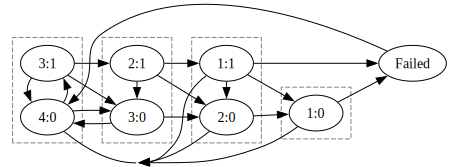

In [10]:
cmm = get_dr_cmm(4, conservative_failure_params)
get_graphviz(cmm, node_to_group=working_and_backup_grouping(cmm))

In [ ]:
# Also try to vary automatic recovery rate + other parameters 5 outputs
# Try to get the 5d symbolic mttf
# Try to generate graphs automatically +++ Good graph visualization
# Try to get parameter sweep sliders for graphs
failure_rates = generate_fractions(Fraction(1, 1000 * 24), Fraction(1, 50 * 24), 1000)
x_axis = [float(x) * 24 * 365.25 for x in failure_rates]
mttf_three_node = []
mttf_five_node = []
mttf_opt_three_node = []
mttf_opt_1b_three_node = []

for failure_rps in failure_rates:
    params = FailureParameters(
        failure_rps=failure_rps,
        recovery_rps=Fraction(1, 5),
        human_recovery_rps=Fraction(1, 5),
        update_rps=Fraction((60 * 60 * 1000), 10),
        outdate_rps=Fraction((60 * 60 * 1000), 10),
    )
    cmm3 = get_three_node_CMM(params)
    cmm5 = get_five_node_CMM(params)
    cmm3opt = get_optimistic_three_node_CMM(params)
    cmm3opt1b = get_optimistic_naiive_backup_three_node_CMM(params)

    cmm3_ans = wolfram_session.evaluate(
        wl.Mean(
            wl.FirstPassageTimeDistribution(
                get_wolfram_markov_model(cmm3), get_state_to_id_dict(cmm3)["Failed"] + 1
            )
        )
    )
    cmm5_ans = wolfram_session.evaluate(
        wl.Mean(
            wl.FirstPassageTimeDistribution(
                get_wolfram_markov_model(cmm5), get_state_to_id_dict(cmm5)["Failed"] + 1
            )
        )
    )
    cmm3opt_ans = wolfram_session.evaluate(
        wl.Mean(
            wl.FirstPassageTimeDistribution(
                get_wolfram_markov_model(cmm3opt),
                get_state_to_id_dict(cmm3opt)["Failed"] + 1,
            )
        )
    )
    cmm3opt_1b_ans = wolfram_session.evaluate(
        wl.Mean(
            wl.FirstPassageTimeDistribution(
                get_wolfram_markov_model(cmm3opt1b),
                get_state_to_id_dict(cmm3opt1b)["Failed"] + 1,
            )
        )
    )

    mttf_three_node.append(convert_wolfram_number(cmm3_ans) / 24 / 365.25)
    mttf_five_node.append(convert_wolfram_number(cmm5_ans) / 24 / 365.25)
    mttf_opt_three_node.append(convert_wolfram_number(cmm3opt_ans) / 24 / 365.25)
    mttf_opt_1b_three_node.append(convert_wolfram_number(cmm3opt_1b_ans) / 24 / 365.25)

In [ ]:
# Also try to vary automatic recovery rate + other parameters 5 outputs
# Try to get the 5d symbolic mttf
# Try to generate graphs automatically +++ Good graph visualization
# Try to get parameter sweep sliders for graphs
failure_rates = generate_fractions(Fraction(1, 1000 * 24), Fraction(1, 50 * 24), 20)
x_axis = [float(x) * 24 * 365.25 for x in failure_rates]

mttf_three_node = []
mttf_four_node = []
mttf_five_node = []
mttf_six_node = []
mttf_seven_node = []

mttf_opt_four_node = []
mttf_opt_five_node = []
mttf_opt_six_node = []
mttf_opt_seven_node = []

mttf_three_one_backup = []
mttf_three_two_backup = []
mttf_three_three_backup = []

mttf_four_one_backup = []
mttf_four_two_backup = []
mttf_four_three_backup = []

mttf_five_one_backup = []
mttf_five_two_backup = []
mttf_five_three_backup = []

mttf_six_one_backup = []
mttf_six_two_backup = []
mttf_six_three_backup = []

backup_arrs = [
    mttf_three_one_backup,
    mttf_three_two_backup,
    mttf_three_three_backup,
    mttf_four_one_backup,
    mttf_four_two_backup,
    mttf_four_three_backup,
    mttf_five_one_backup,
    mttf_five_two_backup,
    mttf_five_three_backup,
    mttf_six_one_backup,
    mttf_six_two_backup,
    mttf_six_three_backup,
]


with WolframLanguageSession(my_wolfram_kernel_path) as wolfram_session:
    for failure_rps in failure_rates:
        params = FailureParameters(
            failure_rps=failure_rps,
            recovery_rps=Fraction(1, 5),
            human_recovery_rps=Fraction(1, 5),
            update_rps=Fraction((60 * 60 * 1000), 10),
            outdate_rps=Fraction((60 * 60 * 1000), 10),
        )
        cmm3 = get_cmm(3, params)
        cmm5 = get_cmm(5, params)
        cmm4 = get_cmm(4, params)
        cmm6 = get_cmm(6, params)
        cmm7 = get_cmm(7, params)

        cmm4opt = get_dr_cmm(4, params)
        cmm5opt = get_dr_cmm(5, params)
        cmm6opt = get_dr_cmm(6, params)
        cmm7opt = get_dr_cmm(7, params)

        cmm3_1b = get_dr_backup_cmm(3, 1, params, params)

        cmm3_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm3),
                    get_state_to_id_dict(cmm3)["Failed"] + 1,
                )
            )
        )
        cmm5_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm5),
                    get_state_to_id_dict(cmm5)["Failed"] + 1,
                )
            )
        )
        cmm4_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm4),
                    get_state_to_id_dict(cmm4)["Failed"] + 1,
                )
            )
        )
        cmm6_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm6),
                    get_state_to_id_dict(cmm6)["Failed"] + 1,
                )
            )
        )
        cmm7_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm7),
                    get_state_to_id_dict(cmm7)["Failed"] + 1,
                )
            )
        )

        cmm4opt_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm4opt),
                    get_state_to_id_dict(cmm4opt)["Failed"] + 1,
                )
            )
        )
        cmm5opt_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm5opt),
                    get_state_to_id_dict(cmm5opt)["Failed"] + 1,
                )
            )
        )
        cmm6opt_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm6opt),
                    get_state_to_id_dict(cmm6opt)["Failed"] + 1,
                )
            )
        )
        cmm7opt_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm7opt),
                    get_state_to_id_dict(cmm7opt)["Failed"] + 1,
                )
            )
        )

        for num_reps in range(3, 7):
            for num_backups in range(1, 4):
                cmm = get_dr_backup_cmm(num_reps, num_backups, params, params)
                cmm_ans = wolfram_session.evaluate(
                    wl.Mean(
                        wl.FirstPassageTimeDistribution(
                            get_wolfram_markov_model(cmm),
                            get_state_to_id_dict(cmm)["Failed"] + 1,
                        )
                    )
                )
                backup_arrs[(num_reps - 3) * 3 + num_backups - 1].append(
                    convert_wolfram_number(cmm_ans) / 24 / 365.25
                )

        cmm3_1b_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm3_1b),
                    get_state_to_id_dict(cmm3_1b)["Failed"] + 1,
                )
            )
        )

        mttf_three_node.append(convert_wolfram_number(cmm3_ans) / 24 / 365.25)
        mttf_five_node.append(convert_wolfram_number(cmm5_ans) / 24 / 365.25)
        mttf_four_node.append(convert_wolfram_number(cmm4_ans) / 24 / 365.25)
        mttf_six_node.append(convert_wolfram_number(cmm6_ans) / 24 / 365.25)
        mttf_seven_node.append(convert_wolfram_number(cmm7_ans) / 24 / 365.25)

        mttf_opt_four_node.append(convert_wolfram_number(cmm4opt_ans) / 24 / 365.25)
        mttf_opt_five_node.append(convert_wolfram_number(cmm5opt_ans) / 24 / 365.25)
        mttf_opt_six_node.append(convert_wolfram_number(cmm6opt_ans) / 24 / 365.25)
        mttf_opt_seven_node.append(convert_wolfram_number(cmm7opt_ans) / 24 / 365.25)
        mttf_three_one_backup.append(convert_wolfram_number(cmm3_1b_ans) / 24 / 365.25)

In [ ]:
y_axis_value_names = [
    (mttf_three_node, "mttf_three_node"),
    (mttf_four_node, "mttf_four_node"),
    (mttf_five_node, "mttf_five_node"),
    (mttf_six_node, "mttf_six_node"),
    (mttf_seven_node, "mttf_seven_node"),
    (mttf_opt_three_node, "mttf_opt_three_node"),
    (mttf_opt_four_node, "mttf_opt_four_node"),
    (mttf_opt_five_node, "mttf_opt_five_node"),
    (mttf_opt_six_node, "mttf_opt_six_node"),
    (mttf_opt_seven_node, "mttf_opt_seven_node"),
    (mttf_opt_1b_three_node, "mttf_opt_1b_three_node"),
    (mttf_three_one_backup, "mttf_three_one_backup"),
    (mttf_three_two_backup, "mttf_three_two_backup"),
    (mttf_three_three_backup, "mttf_three_three_backup"),
    (mttf_four_one_backup, "mttf_four_one_backup"),
    (mttf_four_two_backup, "mttf_four_two_backup"),
    (mttf_four_three_backup, "mttf_four_three_backup"),
    (mttf_five_one_backup, "mttf_five_one_backup"),
    (mttf_five_two_backup, "mttf_five_two_backup"),
    (mttf_five_three_backup, "mttf_five_three_backup"),
    (mttf_six_one_backup, "mttf_six_one_backup"),
    (mttf_six_two_backup, "mttf_six_two_backup"),
    (mttf_six_three_backup, "mttf_six_three_backup"),
]

mttf_vs_failure_rate = Graph(
    title="mttf vs failure rate/year",
    x_axis_name="failure rate/yr",
    y_axis_name="mttf (years)",
    lines=[
        Line(x_values=x_axis, y_values=val_name[0], name=val_name[1])
        for val_name in y_axis_value_names
    ],
)

make_fig(mttf_vs_failure_rate)

In [ ]:
# Also try to vary automatic recovery rate + other parameters 5 outputs
# Try to get the 5d symbolic mttf
# Try to generate graphs automatically +++ Good graph visualization
# Try to get parameter sweep sliders for graphs
failure_rates = generate_fractions(Fraction(1, 5), Fraction(1, 5 * 24 * 10), 40)
x_axis = [float(x) * 24 * 365.25 for x in failure_rates]

mttf_three_node = []
mttf_four_node = []
mttf_five_node = []
mttf_six_node = []
mttf_seven_node = []

mttf_opt_four_node = []
mttf_opt_five_node = []
mttf_opt_six_node = []
mttf_opt_seven_node = []

mttf_three_one_backup = []
mttf_three_two_backup = []
mttf_three_three_backup = []

mttf_four_one_backup = []
mttf_four_two_backup = []
mttf_four_three_backup = []

mttf_five_one_backup = []
mttf_five_two_backup = []
mttf_five_three_backup = []

mttf_six_one_backup = []
mttf_six_two_backup = []
mttf_six_three_backup = []

backup_arrs = [
    mttf_three_one_backup,
    mttf_three_two_backup,
    mttf_three_three_backup,
    mttf_four_one_backup,
    mttf_four_two_backup,
    mttf_four_three_backup,
    mttf_five_one_backup,
    mttf_five_two_backup,
    mttf_five_three_backup,
    mttf_six_one_backup,
    mttf_six_two_backup,
    mttf_six_three_backup,
]


with WolframLanguageSession(my_wolfram_kernel_path) as wolfram_session:
    for failure_rps in failure_rates:
        params = FailureParameters(
            failure_rps=Fraction(1, 50 * 24),
            recovery_rps=Fraction(1, 5),
            human_recovery_rps=failure_rps,
            update_rps=Fraction((60 * 60 * 1000), 10),
            outdate_rps=Fraction((60 * 60 * 1000), 10),
        )
        cmm3 = get_cmm(3, params)
        cmm5 = get_cmm(5, params)
        cmm4 = get_cmm(4, params)
        cmm6 = get_cmm(6, params)
        cmm7 = get_cmm(7, params)

        cmm4opt = get_dr_cmm(4, params)
        cmm5opt = get_dr_cmm(5, params)
        cmm6opt = get_dr_cmm(6, params)
        cmm7opt = get_dr_cmm(7, params)

        cmm3_1b = get_dr_backup_cmm(3, 1, params, params)

        cmm3_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm3),
                    get_state_to_id_dict(cmm3)["Failed"] + 1,
                )
            )
        )
        cmm5_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm5),
                    get_state_to_id_dict(cmm5)["Failed"] + 1,
                )
            )
        )
        cmm4_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm4),
                    get_state_to_id_dict(cmm4)["Failed"] + 1,
                )
            )
        )
        cmm6_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm6),
                    get_state_to_id_dict(cmm6)["Failed"] + 1,
                )
            )
        )
        cmm7_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm7),
                    get_state_to_id_dict(cmm7)["Failed"] + 1,
                )
            )
        )

        cmm4opt_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm4opt),
                    get_state_to_id_dict(cmm4opt)["Failed"] + 1,
                )
            )
        )
        cmm5opt_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm5opt),
                    get_state_to_id_dict(cmm5opt)["Failed"] + 1,
                )
            )
        )
        cmm6opt_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm6opt),
                    get_state_to_id_dict(cmm6opt)["Failed"] + 1,
                )
            )
        )
        cmm7opt_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm7opt),
                    get_state_to_id_dict(cmm7opt)["Failed"] + 1,
                )
            )
        )

        for num_reps in range(3, 7):
            for num_backups in range(1, 4):
                cmm = get_dr_backup_cmm(num_reps, num_backups, params, params)
                cmm_ans = wolfram_session.evaluate(
                    wl.Mean(
                        wl.FirstPassageTimeDistribution(
                            get_wolfram_markov_model(cmm),
                            get_state_to_id_dict(cmm)["Failed"] + 1,
                        )
                    )
                )
                backup_arrs[(num_reps - 3) * 3 + num_backups - 1].append(
                    convert_wolfram_number(cmm_ans) / 24 / 365.25
                )

        cmm3_1b_ans = wolfram_session.evaluate(
            wl.Mean(
                wl.FirstPassageTimeDistribution(
                    get_wolfram_markov_model(cmm3_1b),
                    get_state_to_id_dict(cmm3_1b)["Failed"] + 1,
                )
            )
        )

        mttf_three_node.append(convert_wolfram_number(cmm3_ans) / 24 / 365.25)
        mttf_five_node.append(convert_wolfram_number(cmm5_ans) / 24 / 365.25)
        mttf_four_node.append(convert_wolfram_number(cmm4_ans) / 24 / 365.25)
        mttf_six_node.append(convert_wolfram_number(cmm6_ans) / 24 / 365.25)
        mttf_seven_node.append(convert_wolfram_number(cmm7_ans) / 24 / 365.25)

        mttf_opt_four_node.append(convert_wolfram_number(cmm4opt_ans) / 24 / 365.25)
        mttf_opt_five_node.append(convert_wolfram_number(cmm5opt_ans) / 24 / 365.25)
        mttf_opt_six_node.append(convert_wolfram_number(cmm6opt_ans) / 24 / 365.25)
        mttf_opt_seven_node.append(convert_wolfram_number(cmm7opt_ans) / 24 / 365.25)
        mttf_three_one_backup.append(convert_wolfram_number(cmm3_1b_ans) / 24 / 365.25)

In [ ]:
y_axis_value_names = [
    (mttf_three_node, "mttf_three_node"),
    (mttf_four_node, "mttf_four_node"),
    (mttf_five_node, "mttf_five_node"),
    (mttf_six_node, "mttf_six_node"),
    (mttf_seven_node, "mttf_seven_node"),
    (mttf_opt_three_node, "mttf_opt_three_node"),
    (mttf_opt_four_node, "mttf_opt_four_node"),
    (mttf_opt_five_node, "mttf_opt_five_node"),
    (mttf_opt_six_node, "mttf_opt_six_node"),
    (mttf_opt_seven_node, "mttf_opt_seven_node"),
    (mttf_opt_1b_three_node, "mttf_opt_1b_three_node"),
    (mttf_three_one_backup, "mttf_three_one_backup"),
    (mttf_three_two_backup, "mttf_three_two_backup"),
    (mttf_three_three_backup, "mttf_three_three_backup"),
    (mttf_four_one_backup, "mttf_four_one_backup"),
    (mttf_four_two_backup, "mttf_four_two_backup"),
    (mttf_four_three_backup, "mttf_four_three_backup"),
    (mttf_five_one_backup, "mttf_five_one_backup"),
    (mttf_five_two_backup, "mttf_five_two_backup"),
    (mttf_five_three_backup, "mttf_five_three_backup"),
    (mttf_six_one_backup, "mttf_six_one_backup"),
    (mttf_six_two_backup, "mttf_six_two_backup"),
    (mttf_six_three_backup, "mttf_six_three_backup"),
]

mttf_vs_failure_rate = Graph(
    title="mttf vs failure rate/year",
    x_axis_name="human recovery rate/yr",
    y_axis_name="mttf (years)",
    lines=[
        Line(x_values=x_axis, y_values=val_name[0], name=val_name[1])
        for val_name in y_axis_value_names
    ],
)

make_fig(mttf_vs_failure_rate)